In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.io.wavfile as wav
import scipy.signal as sig

def plot_spectrogram_and_speed(wav_filename, show_plot=True):
    # Read WAV file
    sample_rate, samples = wav.read(wav_filename)
    if samples.ndim > 1:
        samples = samples[:,0]
    duration = samples.shape[0] / sample_rate

    # Compute spectrogram
    nperseg = 1024
    noverlap = nperseg // 2
    f, t, Sxx = sig.spectrogram(samples, sample_rate, nperseg=nperseg, noverlap=noverlap)
    if show_plot:
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(t, f, Sxx, norm=colors.LogNorm(vmin=Sxx.min()+1e-6, vmax=Sxx.max()))
        plt.title("Spectrogram")
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [s]')
        plt.tight_layout()
        plt.show()

    # Analyze speed at 1s, 2s, ... using spectrogram (A3-A5)
    hz_bin_3900 = np.argmin(np.abs(f - 3900))
    avg_noise_power_3900 = np.mean(Sxx[hz_bin_3900])
    print(f"Average noise power at 3900 Hz: {int(round(avg_noise_power_3900))} units")
    c = 3e8
    radar_freq = 10.5e9

    for sec in range(1, int(duration)+1):
        # Get spectrogram column nearest to each second
        col = np.argmin(np.abs(t - sec))
        powers = Sxx[:,col]
        max_idx = np.argmax(powers)
        max_power = powers[max_idx]
        if max_power > avg_noise_power_3900:
            fd = f[max_idx]
            v_ms = fd * c / (2 * radar_freq)
            v_mph = v_ms * 2.23694
            print("t = {} s, v = {:.2f} m/s, v = {:.2f} MPH, target power {}".format(
                sec, v_ms, v_mph, int(round(max_power))
            ))
        else:
            print(f"t = {sec} s, no target")


WAV file saved: car_infinite_rcs.wav


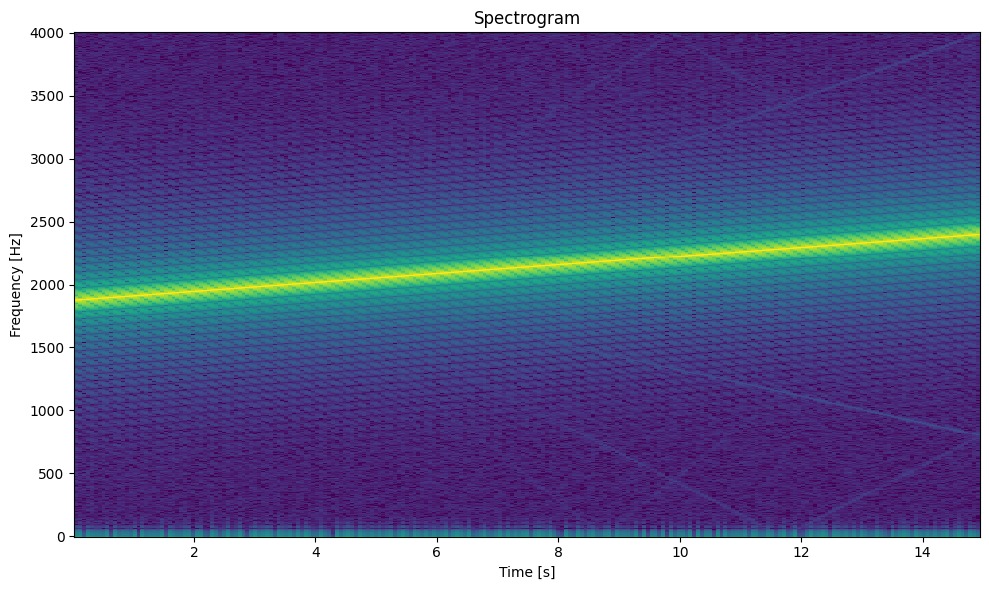

Average noise power at 3900 Hz: 0 units
t = 1 s, v = 27.34 m/s, v = 61.17 MPH, target power 50020744
t = 2 s, v = 27.79 m/s, v = 62.16 MPH, target power 61613024
t = 3 s, v = 28.35 m/s, v = 63.41 MPH, target power 40760444
t = 4 s, v = 28.79 m/s, v = 64.41 MPH, target power 60258956
t = 5 s, v = 29.24 m/s, v = 65.41 MPH, target power 31967766
t = 6 s, v = 29.80 m/s, v = 66.66 MPH, target power 60656788
t = 7 s, v = 30.25 m/s, v = 67.66 MPH, target power 42062704
t = 8 s, v = 30.80 m/s, v = 68.91 MPH, target power 61502088
t = 9 s, v = 31.36 m/s, v = 70.15 MPH, target power 36422956
t = 10 s, v = 31.81 m/s, v = 71.15 MPH, target power 58521280
t = 11 s, v = 32.25 m/s, v = 72.15 MPH, target power 36362176
t = 12 s, v = 32.81 m/s, v = 73.40 MPH, target power 52160432
t = 13 s, v = 33.26 m/s, v = 74.40 MPH, target power 46166532
t = 14 s, v = 33.82 m/s, v = 75.65 MPH, target power 60673220
t = 15 s, v = 34.26 m/s, v = 76.65 MPH, target power 60989928


In [5]:
def generate_test_wav_infinite_rcs(filename="car_infinite_rcs.wav"):
    duration = 15
    fs = 8000
    sim_timevec = np.linspace(0, duration, duration * fs)
    car_v0 = 26.8
    car_acc = 0.5
    radar_freq = 10.5e9
    c = 3e8
    v = car_v0 + sim_timevec * car_acc
    fd = 2 * radar_freq * v / c
    # Infinite RCS: set amplitude constant
    amp = 1.0
    car_sig = amp * np.cos(2 * np.pi * np.cumsum(fd / fs))
    car_sig = (car_sig / np.max(np.abs(car_sig))) * 32767
    car_sig = car_sig.astype(np.int16)
    wav.write(filename, fs, car_sig)
    print(f"WAV file saved: {filename}")
    return filename

filename = generate_test_wav_infinite_rcs()
plot_spectrogram_and_speed(filename, show_plot=True)


WAV file saved: car_rcs_awgn.wav


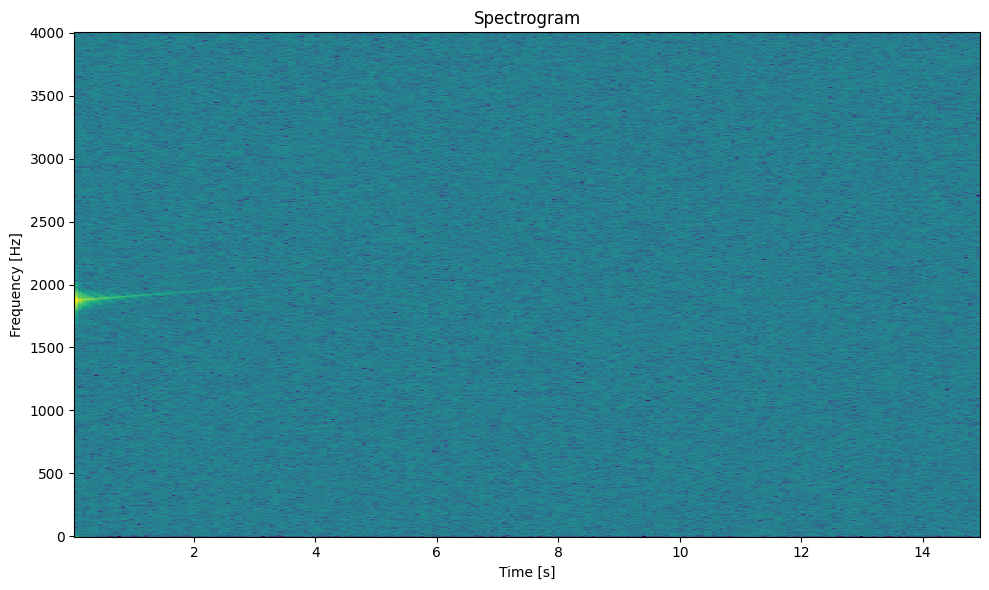

Average noise power at 3900 Hz: 0 units
t = 1 s, v = 27.34 m/s, v = 61.17 MPH, target power 79
t = 2 s, v = 27.79 m/s, v = 62.16 MPH, target power 10
t = 3 s, v = 14.17 m/s, v = 31.71 MPH, target power 3
t = 4 s, v = 28.79 m/s, v = 64.41 MPH, target power 2
t = 5 s, v = 2.57 m/s, v = 5.74 MPH, target power 2
t = 6 s, v = 22.10 m/s, v = 49.43 MPH, target power 1
t = 7 s, v = 50.56 m/s, v = 113.10 MPH, target power 2
t = 8 s, v = 34.60 m/s, v = 77.39 MPH, target power 2
t = 9 s, v = 47.88 m/s, v = 107.10 MPH, target power 1
t = 10 s, v = 7.81 m/s, v = 17.48 MPH, target power 1
t = 11 s, v = 27.68 m/s, v = 61.92 MPH, target power 2
t = 12 s, v = 19.98 m/s, v = 44.69 MPH, target power 2
t = 13 s, v = 1.34 m/s, v = 3.00 MPH, target power 2
t = 14 s, v = 46.65 m/s, v = 104.36 MPH, target power 1
t = 15 s, v = 38.39 m/s, v = 85.88 MPH, target power 1


In [6]:
def generate_test_wav_car_rcs_noise(filename="car_rcs_awgn.wav"):
    duration = 15
    fs = 8000
    sim_timevec = np.linspace(0, duration, duration * fs)
    car_rcs = 100
    car_x0, car_v0, car_acc = 1, 26.8, 0.5
    radar_freq = 10.5e9
    c = 3e8

    v = car_v0 + sim_timevec * car_acc
    fd = 2 * radar_freq * v / c
    car_pos = car_x0 + car_v0 * sim_timevec + 0.5 * car_acc * sim_timevec ** 2
    amp = np.power(car_rcs, 0.5) * np.power(car_pos, -2)
    car_sig = amp * np.cos(2 * np.pi * np.cumsum(fd / fs))
    car_sig = (car_sig / np.max(np.abs(car_sig))) * 32767
    # Add -60 dBFS AWGN
    awgn_db = -60
    noise_power_linear = 10**(awgn_db/10)
    noise_std = np.sqrt(noise_power_linear * 32767**2)
    noise = noise_std * np.random.randn(len(car_sig))
    out_sig = car_sig + noise
    out_sig = (out_sig / np.max(np.abs(out_sig))) * 32767
    out_sig = out_sig.astype(np.int16)
    wav.write(filename, fs, out_sig)
    print(f"WAV file saved: {filename}")
    return filename

filename = generate_test_wav_car_rcs_noise()
plot_spectrogram_and_speed(filename, show_plot=True)
